In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [13]:
batch_size = 128
num_epochs = 8
num_classes = 10
learning_rate = 0.002
seed = 42

mnist_train = datasets.MNIST(
    "/content/sample_data", download=True, train=True,
    transform=transforms.ToTensor()
)
mnist_test = datasets.MNIST(
    "/content/sample_data", train=False, transform=transforms.ToTensor()
)

train_data = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_data = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

len_train, len_test = len(mnist_train), len(mnist_test)
print(f"Ejemplos de entrenamiento: {len_train} | Ejemplos de prueba: {len_test}")

Ejemplos de entrenamiento: 60000 | Ejemplos de prueba: 10000


In [10]:
class LeNet5Base(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size = 2, stride = 2))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(400, 120)
        self.tanh = nn.Tanh()
        self.fc1 = nn.Linear(120, 84)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.flatten(out)
        out = self.fc(out)
        out = self.tanh(out)
        out = self.fc1(out)
        out = self.tanh1(out)
        out = self.fc2(out)
        return out

In [11]:
class LeNet5Dropout(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size = 2, stride = 2))
        self.drop_layer = nn.Dropout(0.5)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(400, 120)
        self.tanh = nn.Tanh()
        self.fc1 = nn.Linear(120, 84)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.drop_layer(out)
        out = self.flatten(out)
        out = self.fc(out)
        out = self.tanh(out)
        out = self.fc1(out)
        out = self.tanh1(out)
        out = self.fc2(out)
        return out

In [12]:
class LeNet5BatchNorm(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(6),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size = 2, stride = 2))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(400, 120)
        self.tanh = nn.Tanh()
        self.fc1 = nn.Linear(120, 84)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.flatten(out)
        out = self.fc(out)
        out = self.tanh(out)
        out = self.fc1(out)
        out = self.tanh1(out)
        out = self.fc2(out)
        return out

### Base Model

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_base = LeNet5Base(num_classes).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_base.parameters(), lr = learning_rate)
train_accuracy_base = []
test_accuracy_base = []

for epoch in tqdm(range(num_epochs)):
  train_correct = 0
  test_correct = 0
  train_total = 0
  test_total = 0

  for images, labels in train_data:
    images, labels = images.to(device), labels.to(device)
    model_base.eval()

    with torch.no_grad():
      predictions = model_base(images)
      train_total += labels.size(0)
      _, predictions = torch.max(model_base(images).data, 1)
      train_correct += (predictions == labels).sum().item()

    model_base.train()
    predictions = model_base(images)
    loss = loss_function(predictions, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  for images, labels in test_data:
    images, labels = images.to(device), labels.to(device)
    model_base.eval()

    with torch.no_grad():
      _, predictions = torch.max(model_base(images).data, 1)
      test_total += labels.size(0)
      test_correct += (predictions == labels).sum().item()

  train_accuracy = 100 * train_correct / train_total
  test_accuracy = 100 * test_correct / test_total
  train_accuracy_base += [train_accuracy]
  test_accuracy_base += [test_accuracy]
  print(f"Epoch: {epoch + 1}| Train acc: {train_accuracy: .4f}| Test acc: {test_accuracy: .4f}")

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1| Train acc:  91.5650| Test acc:  96.1600
Epoch: 2| Train acc:  97.0450| Test acc:  97.2500
Epoch: 3| Train acc:  98.0617| Test acc:  97.8700
Epoch: 4| Train acc:  98.4717| Test acc:  97.8900
Epoch: 5| Train acc:  98.7717| Test acc:  98.3000
Epoch: 6| Train acc:  98.9683| Test acc:  98.5000
Epoch: 7| Train acc:  99.0400| Test acc:  98.4600
Epoch: 8| Train acc:  99.2533| Test acc:  98.6100


### Model w/ Dropout Layer

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_dropout = LeNet5Dropout(num_classes).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_dropout.parameters(), lr = learning_rate)
train_accuracy_dropout = []
test_accuracy_dropout = []

for epoch in tqdm(range(num_epochs)):
  train_correct = 0
  test_correct = 0
  train_total = 0
  test_total = 0

  for images, labels in train_data:
    images, labels = images.to(device), labels.to(device)
    model_dropout.eval()

    with torch.no_grad():
      predictions = model_dropout(images)
      train_total += labels.size(0)
      _, predictions = torch.max(model_dropout(images).data, 1)
      train_correct += (predictions == labels).sum().item()

    model_dropout.train()
    predictions = model_dropout(images)
    loss = loss_function(predictions, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  for images, labels in test_data:
    images, labels = images.to(device), labels.to(device)
    model_dropout.eval()

    with torch.no_grad():
      _, predictions = torch.max(model_dropout(images).data, 1)
      test_total += labels.size(0)
      test_correct += (predictions == labels).sum().item()

  train_accuracy = 100 * train_correct / train_total
  test_accuracy = 100 * test_correct / test_total
  train_accuracy_dropout += [train_accuracy]
  test_accuracy_dropout += [test_accuracy]
  print(f"Epoch: {epoch + 1}| Train acc: {train_accuracy: .4f}| Test acc: {test_accuracy: .4f}")

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1| Train acc:  89.7550| Test acc:  95.6200
Epoch: 2| Train acc:  96.3300| Test acc:  96.9400
Epoch: 3| Train acc:  97.3983| Test acc:  97.6300
Epoch: 4| Train acc:  97.8550| Test acc:  98.0200
Epoch: 5| Train acc:  98.1233| Test acc:  98.1000
Epoch: 6| Train acc:  98.4200| Test acc:  98.1300
Epoch: 7| Train acc:  98.6933| Test acc:  98.3500
Epoch: 8| Train acc:  98.7183| Test acc:  98.4700


### Model w/ Batch Normalization Layer

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_batch_norm = LeNet5BatchNorm(num_classes).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_batch_norm.parameters(), lr = learning_rate)
train_accuracy_batch_norm = []
test_accuracy_batch_norm = []

for epoch in tqdm(range(num_epochs)):
  train_correct = 0
  test_correct = 0
  train_total = 0
  test_total = 0

  for images, labels in train_data:
    images, labels = images.to(device), labels.to(device)
    model_batch_norm.eval()

    with torch.no_grad():
      predictions = model_batch_norm(images)
      train_total += labels.size(0)
      _, predictions = torch.max(model_batch_norm(images).data, 1)
      train_correct += (predictions == labels).sum().item()

    model_batch_norm.train()
    predictions = model_batch_norm(images)
    loss = loss_function(predictions, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  for images, labels in test_data:
    images, labels = images.to(device), labels.to(device)
    model_batch_norm.eval()

    with torch.no_grad():
      _, predictions = torch.max(model_batch_norm(images).data, 1)
      test_total += labels.size(0)
      test_correct += (predictions == labels).sum().item()

  train_accuracy = 100 * train_correct / train_total
  test_accuracy = 100 * test_correct / test_total
  train_accuracy_batch_norm += [train_accuracy]
  test_accuracy_batch_norm += [test_accuracy]
  print(f"Epoch: {epoch + 1}| Train acc: {train_accuracy: .4f}| Test acc: {test_accuracy: .4f}")

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1| Train acc:  93.3000| Test acc:  97.9600
Epoch: 2| Train acc:  97.9333| Test acc:  97.8400
Epoch: 3| Train acc:  98.3950| Test acc:  97.5500
Epoch: 4| Train acc:  98.6067| Test acc:  97.7500
Epoch: 5| Train acc:  98.5633| Test acc:  98.2800
Epoch: 6| Train acc:  98.9933| Test acc:  98.5900
Epoch: 7| Train acc:  99.1583| Test acc:  98.8500
Epoch: 8| Train acc:  99.1717| Test acc:  98.9000


### Model Optimized w/ Weight Decay

Weight decay (in this case, L2 decay) is a small modification to the loss function (and therefor the gradient) that adds a penalty term to the weights between neurons. (Remember Ridge regressions)

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_decay = LeNet5Base(num_classes).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_decay.parameters(), lr = learning_rate, weight_decay = .001)
train_accuracy_decay = []
test_accuracy_decay = []

for epoch in tqdm(range(num_epochs)):
  train_correct = 0
  test_correct = 0
  train_total = 0
  test_total = 0

  for images, labels in train_data:
    images, labels = images.to(device), labels.to(device)
    model_decay.eval()

    with torch.no_grad():
      predictions = model_decay(images)
      train_total += labels.size(0)
      _, predictions = torch.max(model_decay(images).data, 1)
      train_correct += (predictions == labels).sum().item()

    model_decay.train()
    predictions = model_decay(images)
    loss = loss_function(predictions, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  for images, labels in test_data:
    images, labels = images.to(device), labels.to(device)
    model_decay.eval()

    with torch.no_grad():
      _, predictions = torch.max(model_decay(images).data, 1)
      test_total += labels.size(0)
      test_correct += (predictions == labels).sum().item()

  train_accuracy = 100 * train_correct / train_total
  test_accuracy = 100 * test_correct / test_total
  train_accuracy_decay += [train_accuracy]
  test_accuracy_decay += [test_accuracy]
  print(f"Epoch: {epoch + 1}| Train acc: {train_accuracy: .4f}| Test acc: {test_accuracy: .4f}")

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1| Train acc:  91.4733| Test acc:  96.0300
Epoch: 2| Train acc:  96.8217| Test acc:  97.6700
Epoch: 3| Train acc:  97.5867| Test acc:  97.5600
Epoch: 4| Train acc:  97.8933| Test acc:  98.2500
Epoch: 5| Train acc:  97.9367| Test acc:  97.9100
Epoch: 6| Train acc:  98.1067| Test acc:  98.4900
Epoch: 7| Train acc:  98.1867| Test acc:  98.0600
Epoch: 8| Train acc:  98.2750| Test acc:  98.2300


## Illustrative Graphs

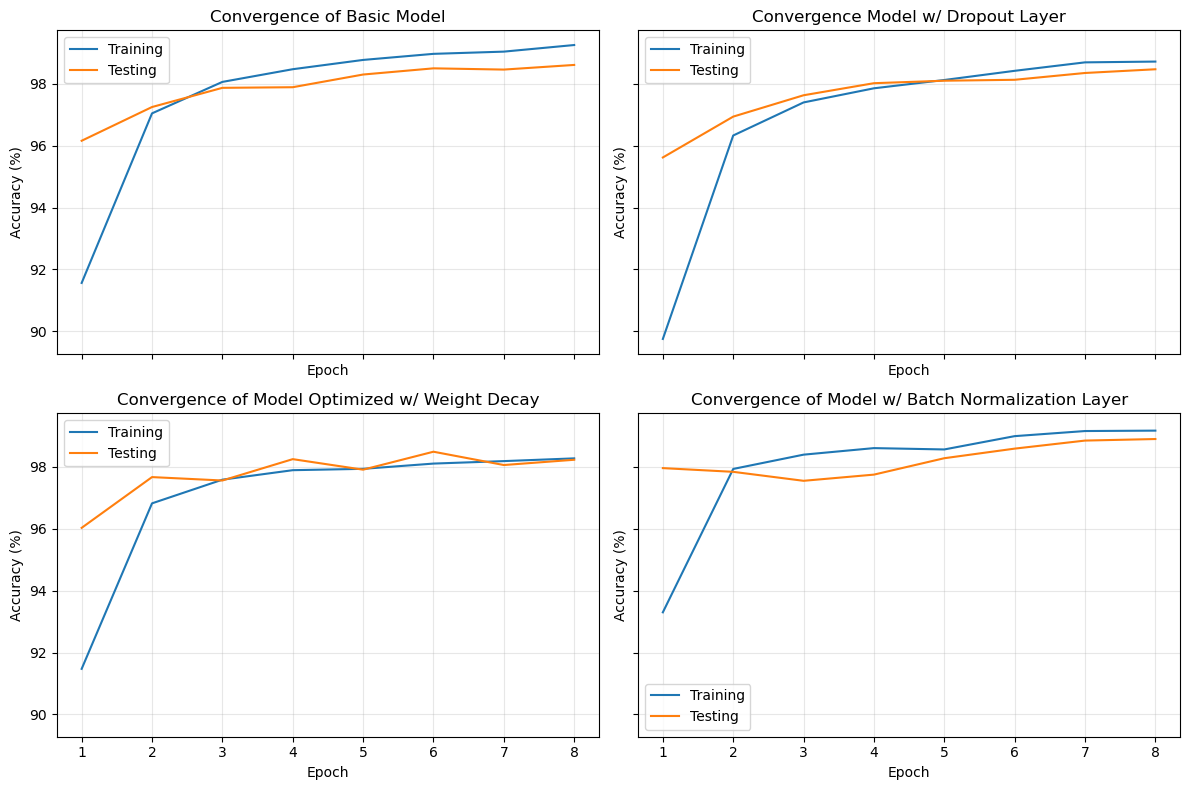

In [20]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

# --- Subplot 1: Modelo básico ---
axs[0, 0].plot(epochs, train_accuracy_base, label="Training")
axs[0, 0].plot(epochs, test_accuracy_base, label="Testing")
axs[0, 0].set_title("Convergence of Basic Model")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Accuracy (%)")
axs[0, 0].grid(True, alpha=0.3)
axs[0, 0].legend()

# --- Subplot 2: Modelo con Dropout ---
axs[0, 1].plot(epochs, train_accuracy_dropout, label="Training")
axs[0, 1].plot(epochs, test_accuracy_dropout, label="Testing")
axs[0, 1].set_title("Convergence Model w/ Dropout Layer")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Accuracy (%)")
axs[0, 1].grid(True, alpha=0.3)
axs[0, 1].legend()

# --- Subplot 3: Modelo con Weight Decay ---
axs[1, 0].plot(epochs, train_accuracy_decay, label="Training")
axs[1, 0].plot(epochs, test_accuracy_decay, label="Testing")
axs[1, 0].set_title("Convergence of Model Optimized w/ Weight Decay")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Accuracy (%)")
axs[1, 0].grid(True, alpha=0.3)
axs[1, 0].legend()

# --- Subplot 4: Modelo con BatchNorm ---
axs[1, 1].plot(epochs, train_accuracy_batch_norm, label="Training")
axs[1, 1].plot(epochs, test_accuracy_batch_norm, label="Testing")
axs[1, 1].set_title("Convergence of Model w/ Batch Normalization Layer")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Accuracy (%)")
axs[1, 1].grid(True, alpha=0.3)
axs[1, 1].legend()

plt.tight_layout()
plt.show()

In [21]:
import pandas as pd
model_names = ["Base", "Dropout", "Weight Decay", "Batch Normalization"]
final_train_accuracies = [train_accuracy_base[-1], train_accuracy_dropout[-1], train_accuracy_decay[-1], train_accuracy_batch_norm[-1]]
final_test_accuracies = [test_accuracy_base[-1], test_accuracy_dropout[-1], test_accuracy_decay[-1], test_accuracy_batch_norm[-1]]

pd.DataFrame({
    "Model": model_names,
    "Training Accuracy": final_train_accuracies,
    "Testing Accuracy": final_test_accuracies
})

,Model,Training Accuracy,Testing Accuracy
0,Base,99.253333,98.61
1,Dropout,98.718333,98.47
2,Weight Decay,98.275000,98.23
3,Batch Normalization,99.171667,98.90


In [22]:
torch.save(model_base, "model_base.pt")
torch.save(model_dropout, "model_dropout.pt")
torch.save(model_decay, "model_decay.pt")
torch.save(model_batch_norm, "model_batch_norm.pt")